In [1]:
%cd /home/luzinsan/Innopolis/Innopolis/2\ semester/Advanced_Machine_Learning/Labs/lab1/

/home/luzinsan/Innopolis/Innopolis/2 semester/Advanced_Machine_Learning/Labs/lab1


/home/luzinsan/Innopolis/Innopolis/2 semester/Advanced_Machine_Learning/ml/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Lab 1 : Generative Models (Autoencoders)
```
- [S25] Advanced Machine Learning, Innopolis University
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Undercomplete, overcomplete, Sparse and Denoising Autoencoder
2. Task 1
3. Variational Autoencoders
4. Task 2
```

<hr>

## 1. Undercomplete, overcomplete, Sparse and Denoising Autoencoder

PCA vs. Undercomplete autoencoders
* Autoencoders are much flexible than PCA.
* Neural Network activation functions introduce “non-linearities” in encoding, but PCA only linear transformation.

### 1.1 Undercomplete Example

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

import torchvision
import torchvision.transforms as transforms


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 1.2 Defining Undercomplete Autoencoder

In [3]:
## Undercomplete
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
      super(autoencoder, self).__init__()
      # Step 1 : Define the encoder
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, latent_dim)
      )

      # Step 2 : Define the decoder
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, input_size)
      )

      # Step 3 : Initialize the weights (optional)
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)

    def forward(self, x):
      # Step 1: Pass the input through encoder to get latent representation
      z = self.encoder(x)
      # Step 2: Take latent representation and pass through decoder
      x = self.decoder(z)
      return x

    def encode(self,input):
      #Step 1: Pass the input through the encoder to get latent representation
      return self.encoder(input)

    def __init_weights(self,m):
      #Init the weights (optional)
      if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

### 1.3 Define training parameters

```
Step 1: Set training parameters (batch size, learning rate, optimizer, number of epochs, loss function)
Step 2: Create dataset (Randomly generated)
Step 3: Create data loader
Step 4: Define the training loop
```

In [4]:
batchSize = 100
learning_rate = 0.01
num_epochs = 3
AE = autoencoder(64,5).to(device)
print(AE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(AE.parameters(),lr=learning_rate)

# Create a random dataset
dataset = torch.randn((1000,1,64))
data_loader = DataLoader(TensorDataset(dataset), batch_size=batchSize,shuffle=True)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=5, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
)


### 1.4 AE Training Loop

In [5]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X in data_loader:
        X = X[0].to(device)

        optimizer.zero_grad()
        # forward
        output = AE(X)
        loss = criterion(output, X)

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

epoch [1/3], loss:0.9778
epoch [2/3], loss:0.9404
epoch [3/3], loss:0.9351


## 2. Task 1 (Regularized Autoencoder)

Regularized autoencoders use a loss function that encourages the model to have other properties besides the ability to copy its input to its output.

* **Sparse Autoencoders** : It impose a constraint in its loss by adding a regularization term in the loss function.
$$L(x,\hat{x}) + λ \sum_{i}||h_i||$$
where $h_i$ is the activations of the hidden layers

  **Regularization Form** : It can be L1 regularization or Any other kinds of penalties are possible


* **Denoising Autoencoder** : a special autoencoder that is robust to noise. By adding stochastic noise, we force Autoencoder to learn more robust features


<font color='red'><strong>TASK 1.1 :</strong> Implement and train a Sparse Autoencoder for 1D data of your choice (data points should be more than 5000)</font>


<font color='red'><strong>TASK 1.2 :</strong> Implement and train a Denoising Autoencoder for CIFAR 10 dataset. Choose one class from the 10 classes</font>


#### TASK 1.1 :</strong> Implement and train a Sparse Autoencoder for 1D data of your choice (data points should be more than 5000)

In [6]:
import matplotlib.pyplot as plt

In [7]:
class SparseAutoencoder(autoencoder):

    def loss_func(self, X, criterion, lambda_reg=0.1):
        return criterion(self(X), X) \
            + lambda_reg * self.encode(X).abs().sum()
    
    def generate_images(self, batch_size, size=(1, 28, 28), z_dim=128, figsize=(8,10)):
        plt.figure(figsize=figsize)
        with torch.no_grad():
            z = torch.randn(batch_size, z_dim)
            out = self.to('cpu').decoder(z).view(batch_size, *size).permute(0, 2, 3, 1)
            for i in range(batch_size):
                plt.subplot(1, batch_size, i+1)
                plt.imshow(out[i], cmap='Grays')

Text(0.5, 1.0, 'tensor(9)')

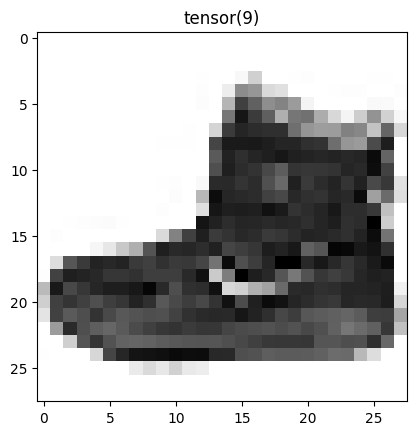

In [8]:
from torchvision.datasets import FashionMNIST 
import matplotlib.pyplot as plt
df_fashion = FashionMNIST(root='./data/', transform=transforms.ToTensor(), download=True)
input_size = df_fashion.data[0].shape[0]

plt.imshow(df_fashion.data[0], cmap='Grays')
plt.title(df_fashion.targets[0])

In [9]:
batchSize = 16
learning_rate = 0.0001
num_epochs = 10

In [10]:
## Training Sparse Autoencoder
SAE = SparseAutoencoder(784, 128).to(device)

optimizer = torch.optim.Adam(SAE.parameters(),lr=learning_rate)
data_loader = DataLoader(df_fashion, batch_size=batchSize, shuffle=True)
criterion = nn.BCEWithLogitsLoss()

print(SAE)
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X in data_loader:
        X = X[0].flatten(1).unsqueeze(1).to(device)
        optimizer.zero_grad()
        # forward
        loss = SAE.loss_func(X, criterion, 0.2)
        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    losses.append(loss.item())

SparseAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=784, bias=True)
  )
)
epoch [1/10], loss:0.5110
epoch [2/10], loss:0.4676
epoch [3/10], loss:0.7012
epoch [4/10], loss:0.4493
epoch [5/10], loss:0.5023
epoch [6/10], loss:0.5121
epoch [7/10], loss:0.4968
epoch [8/10], loss:0.4984
epoch [9/10], loss:0.5014
epoch [10/10], loss:0.4944


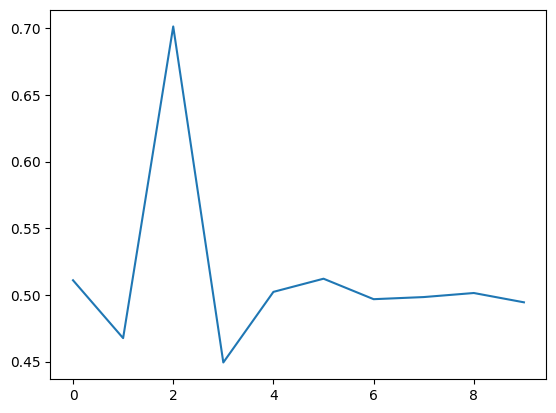

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(losses)

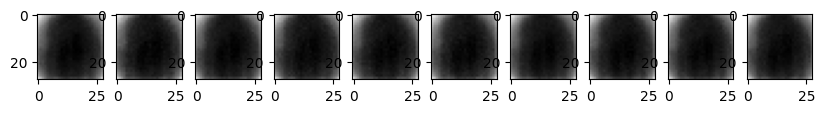

In [12]:
SAE.generate_images(10, (1, *df_fashion.data.shape[1:]), figsize=(10, 10))

#### TASK 1.2 :</strong> Implement and train a Denoising Autoencoder for CIFAR 10 dataset. Choose one class from the 10 classes

/home/luzinsan/Innopolis/Innopolis/2 semester/Advanced_Machine_Learning/ml/.venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Text(0.5, 1.0, '6')

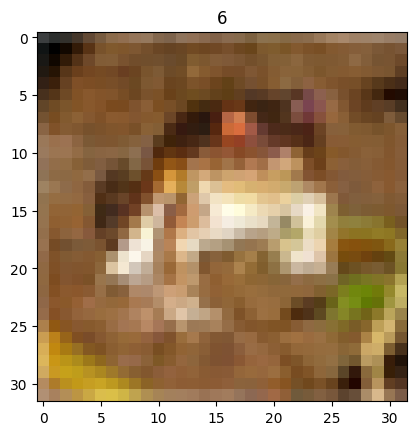

In [13]:
from torchvision.datasets import CIFAR10 
from torchvision.transforms import v2
df_cifar10 = CIFAR10(root='./data/', 
                     transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.ToTensor()]), 
                     download=True)
input_size = df_cifar10.data[0].shape[0]

plt.imshow(df_cifar10.data[0])
plt.title(df_cifar10.targets[0])

In [14]:
import numpy as np
spec_class = 6
cifar_frog_indexes = np.where(np.array(df_cifar10.targets) == spec_class)
df_frog = df_cifar10.data[cifar_frog_indexes]

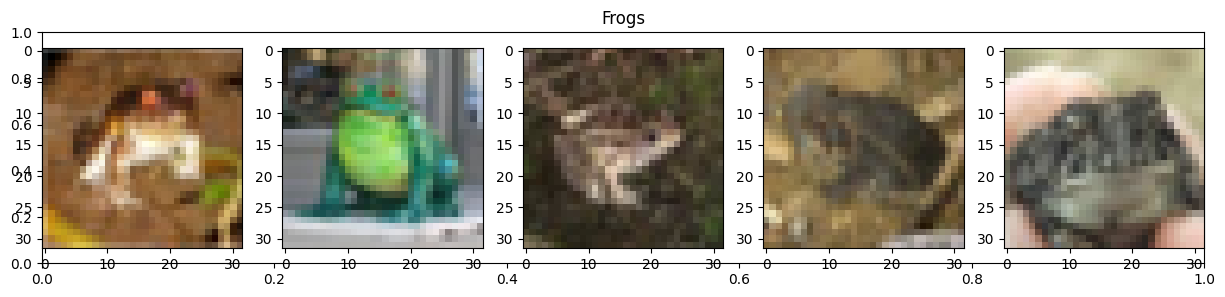

In [15]:
plt.figure(figsize=(15, 3))
plt.title('Frogs')
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(df_frog[i])

In [16]:
class DenoisingAutoencoder(autoencoder):
    def loss_func(self, X, criterion, lambda_reg=0.0):
        X_noised = X \
            + torch.rand_like(X) \
                * lambda_reg  # with Gaussian noise
        out = self(X_noised.view(X.shape[0], 1, -1)).reshape(*X.shape)
        return criterion(out, X) 
    

    def denoise_images(self, X, batch_size, size=(32, 32, 3), z_dim=128, figsize=(8,10)):
        plt.figure(figsize=figsize)
        X = torch.tensor(X).float()
        with torch.no_grad():
            
            out = self.to('cpu')(X).view(batch_size, *size)
            for i in range(batch_size):
                plt.subplot(2, batch_size, i+1)
                plt.imshow(X[i].view(*size))
                plt.subplot(2, batch_size, batch_size + i+1)
                plt.imshow(out[i])

In [17]:
batchSize = 64
learning_rate = 1e-3
num_epochs = 10

#Create a random dataset
data_loader = DataLoader(df_frog, batch_size=batchSize,shuffle=True)

In [18]:
## Training Denoising Autoencoder
DAE = DenoisingAutoencoder(input_size*input_size*3, 128).to(device)
print(DAE)
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(DAE.parameters(), lr=learning_rate)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1536, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1536, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=1536, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1536, out_features=3072, bias=True)
  )
)


In [19]:


losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for X in data_loader:
        X = X.to(device)
        optimizer.zero_grad()
        # forward
        loss = DAE.loss_func(X.float(), criterion, 0.9) 

        # backward
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    losses.append(loss.item())

epoch [1/10], loss:1793.6521
epoch [2/10], loss:821.7559
epoch [3/10], loss:1008.1490
epoch [4/10], loss:763.7409
epoch [5/10], loss:935.5197
epoch [6/10], loss:804.3559
epoch [7/10], loss:892.1499
epoch [8/10], loss:671.0933
epoch [9/10], loss:803.3881
epoch [10/10], loss:838.8198


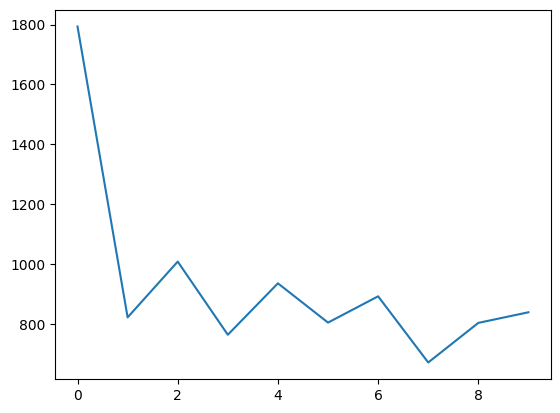

In [20]:
import matplotlib.pyplot as plt
plt.figure()
# plt.yscale('log')
plt.plot(range(num_epochs), losses)

## 3. Variational Autoencoders

![caption](https://learnopencv.com/wp-content/uploads/2020/11/vae-diagram-1-1024x563.jpg)


![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-2048x959.jpg)

Backpropagation works fine!!
However, we simply cannot do this for a random sampling process.

$$z \sim q(z|x^{i})$$

* It is basically divert the non-differentiable operation out of the network
* So that, even though we still involve a thing that is non-differentiable, at least it is out of the network
* Hence the network could still be trained.

To do so, we sample $\epsilon \sim N(0,I)$ and calculate:

$$z = \mu_{\phi}(x^{(i)}) + Σ^{1/2}_{\phi}(x^{(i)})\epsilon$$

**Key theories behind :** <br>
1. Change of variable
2. Loacation-Scale Transformation
3. [Law of The Unconscious Statistician](https://en.wikipedia.org/wiki/Law_of_the_unconscious_statistician)
4. [Evidence lower bound (ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)

Then, $z$ will be a sample from $q(z|x^{(i)})$ as its a linear transformation of $\epsilon$ with mean $\mu_{\phi}(x^{(i)})$ and covariance $Σ^{1/2}_{\phi}(x^{(i)})$.

The sampling operation now occurs only for $\epsilon$, which we don’t need to backpropagate through.


**NOTE:** make a simplifying assumption that our covariance matrix only has nonzero values on the diagonal, allowing us to describe this information in a simple vector.

**NOTE** In order to deal with the fact that the network may learn negative values for $σ$ , we'll typically have the network learn $log$ $\sigma$ and exponentiate this value to get the latent distribution's variance

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 3.1 Get data (MNIST) and set Hyper-parameters

In [3]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 5
batch_size = 128
learning_rate = 1e-3

# MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

### 3.2 Defining Variational Autoencoder

In [4]:
# VAE model
class VAE(nn.Module):
  def __init__(self, image_size=784, h_dim=400, z_dim=20):
    super(VAE, self).__init__()
    # Encoder part
    self.fc1 = nn.Linear(image_size, h_dim)

    self.fc2 = nn.Linear(h_dim, z_dim)
    self.fc3 = nn.Linear(h_dim, z_dim)

    # Decoder part
    self.fc4 = nn.Linear(z_dim, h_dim)
    self.fc5 = nn.Linear(h_dim, image_size)

  def encode(self, x):
    h = F.relu(self.fc1(x))
    return self.fc2(h), self.fc3(h)

  def reparameterize(self, mu, log_var):
    std = torch.exp(log_var/2)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = F.relu(self.fc4(z))
    return F.sigmoid(self.fc5(h))

  def forward(self, x):
    mu, log_var = self.encode(x)
    z = self.reparameterize(mu, log_var)
    x_reconst = self.decode(z)
    return x_reconst, mu, log_var

### 3.3 Training Variational Autoencoder

In [5]:
model = VAE(image_size, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# Start training
mse_loss = nn.MSELoss()
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = mse_loss(x_reconst, x)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))

    with torch.no_grad():
        # Save the sampled images
        z = torch.randn(batch_size, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)
        save_image(out,'./data/sampled-{}.png'.format(epoch+1))

        # Save the reconstructed images
        out, _, _ = model(x)
        x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
        save_image(x_concat, './data/reconst-{}.png'.format(epoch+1))

Epoch[1/5], Step [10/469], Reconst Loss: 0.1242
Epoch[1/5], Step [20/469], Reconst Loss: 0.0835
Epoch[1/5], Step [30/469], Reconst Loss: 0.0716
Epoch[1/5], Step [40/469], Reconst Loss: 0.0685
Epoch[1/5], Step [50/469], Reconst Loss: 0.0702
Epoch[1/5], Step [60/469], Reconst Loss: 0.0698
Epoch[1/5], Step [70/469], Reconst Loss: 0.0721
Epoch[1/5], Step [80/469], Reconst Loss: 0.0681
Epoch[1/5], Step [90/469], Reconst Loss: 0.0681
Epoch[1/5], Step [100/469], Reconst Loss: 0.0725
Epoch[1/5], Step [110/469], Reconst Loss: 0.0677
Epoch[1/5], Step [120/469], Reconst Loss: 0.0731
Epoch[1/5], Step [130/469], Reconst Loss: 0.0707
Epoch[1/5], Step [140/469], Reconst Loss: 0.0663
Epoch[1/5], Step [150/469], Reconst Loss: 0.0685
Epoch[1/5], Step [160/469], Reconst Loss: 0.0680
Epoch[1/5], Step [170/469], Reconst Loss: 0.0678
Epoch[1/5], Step [180/469], Reconst Loss: 0.0717
Epoch[1/5], Step [190/469], Reconst Loss: 0.0721
Epoch[1/5], Step [200/469], Reconst Loss: 0.0693
Epoch[1/5], Step [210/469], R

KeyboardInterrupt: 

## 4. Task 2 (variational autoencoder)

<font color='red'><strong>TASK 2.1 :</strong> Implement and train a variational autoencoder for cifar 10 data using the achitecture below for encoder and decoder as baseline (you can only improve the achitecture by extending the achitecture on top of baseline) </font>
<br>

<font color='red'><strong>TASK 2.2 :</strong> Implement a function that will generate images using the implemented vae</font>  


**Encoder Achitecture (baseline)**
- 3 convolutional layers whereby each layer is followed by batch normalization and relu activation function
  - Layer 1 : applies 32 filters
  - Layer 2 : applies 64 filters
  - Layer 3 : applies 128 filters

**Latent space**
- without activation

**Decoder Achitecture (baseline)**
- 3 deconvolutional layers whereby each layer is followed by batch normalization and relu activation function
- Mirror of the encoder network

**NB**: For both convolution and deconvolution `kernel_size=4, stride=2, padding=1`

In [3]:
# VAE model
class Conv_VAE(nn.Module):
  def __init__(self, z_dim=20):
    # Start from size (3, 32, 32)
    
    super(Conv_VAE, self).__init__()
    # Recap: Formula of resulting shape after convolution operation
    # p = (p - k + 2p) / s + 1, where k=filter size, p-padding, s-stride
    # Encoder part
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    # (32 - 4 + 2) / 2 + 1 = 16 (32, 16, 16)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    # (16 - 4 + 2) / 2 + 1 = 8 (64, 8, 8) 
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    # (8 - 4 + 2) / 2 + 1 = 4 (128, 4, 4) 
    self.flatten = nn.Flatten()
    # 128 * 4 * 4 = 2048
    self.mu     = nn.Linear(2048, z_dim)
    self.logvar = nn.Linear(2048, z_dim)

    # Decoder part
    self.fc1 = nn.Linear(z_dim, 2048)
    self.unflatten = nn.Unflatten(1, (128, 4, 4))
    # define the transposed convolutional layers for the decoder to upsample
    # and generate the reconstructed image
    self.deconv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
    self.bn5 = nn.BatchNorm2d(64)
    self.deconv2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(32)
    self.deconv3 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)
    

    
  def encode(self, x):
    h = F.relu(self.bn1(self.conv1(x)))
    h = F.relu(self.bn2(self.conv2(h)))
    h = F.relu(self.bn3(self.conv3(h)))
    h = self.flatten(h)
    
    return self.mu(h), self.logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, z):
    h = F.relu(self.fc1(z))
    h = self.unflatten(h)
    h = F.relu(self.bn5(self.deconv1(h)))
    h = F.relu(self.bn6(self.deconv2(h)))
    h = self.deconv3(h)

    return torch.sigmoid(h)

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparameterize(mu, logvar)
    x_reconst = self.decode(z)
    return x_reconst, mu, logvar


In [39]:
# Hyper-parameters
image_size = 32*32*3
z_dim = 128

# CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data/',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)


vae_model = Conv_VAE(z_dim).to(device)
bce_loss = nn.BCELoss(reduction='sum')

vae_model

Conv_VAE(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=2048, out_features=128, bias=True)
  (logvar): Linear(in_features=2048, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=2048, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 4, 4))
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): C

In [40]:
from torchsummary import summary
summary(vae_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]           1,568
       BatchNorm2d-2           [-1, 32, 16, 16]              64
            Conv2d-3             [-1, 64, 8, 8]          32,832
       BatchNorm2d-4             [-1, 64, 8, 8]             128
            Conv2d-5            [-1, 128, 4, 4]         131,200
       BatchNorm2d-6            [-1, 128, 4, 4]             256
           Flatten-7                 [-1, 2048]               0
            Linear-8                  [-1, 128]         262,272
            Linear-9                  [-1, 128]         262,272
           Linear-10                 [-1, 2048]         264,192
        Unflatten-11            [-1, 128, 4, 4]               0
  ConvTranspose2d-12             [-1, 64, 8, 8]         131,136
      BatchNorm2d-13             [-1, 64, 8, 8]             128
  ConvTranspose2d-14           [-1, 32,

In [41]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate, betas=(0.8, 0.999))

In [42]:
# Data loader
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [43]:
vae_model.to('cuda')

Conv_VAE(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mu): Linear(in_features=2048, out_features=128, bias=True)
  (logvar): Linear(in_features=2048, out_features=128, bias=True)
  (fc1): Linear(in_features=128, out_features=2048, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(128, 4, 4))
  (deconv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): C

In [44]:
# Start training
losses = []
num_epochs = 5
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device)
        x_reconst, mu, log_var = vae_model(x)

        # Compute reconstruction loss and kl divergence
        reconst_loss = bce_loss(x_reconst, x)
        kl_div = - 0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

        # Backprop and optimize
        beta = 0.2
        loss = reconst_loss + kl_div * beta
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
            losses.append(reconst_loss.item())


Epoch[1/5], Step [10/391], Reconst Loss: 266213.9375
Epoch[1/5], Step [20/391], Reconst Loss: 256395.2500
Epoch[1/5], Step [30/391], Reconst Loss: 245206.6719
Epoch[1/5], Step [40/391], Reconst Loss: 244126.8281
Epoch[1/5], Step [50/391], Reconst Loss: 242575.4844
Epoch[1/5], Step [60/391], Reconst Loss: 238485.6875
Epoch[1/5], Step [70/391], Reconst Loss: 240586.6562
Epoch[1/5], Step [80/391], Reconst Loss: 238389.0938
Epoch[1/5], Step [90/391], Reconst Loss: 232608.5781
Epoch[1/5], Step [100/391], Reconst Loss: 235792.3438
Epoch[1/5], Step [110/391], Reconst Loss: 233700.6094
Epoch[1/5], Step [120/391], Reconst Loss: 233167.6250
Epoch[1/5], Step [130/391], Reconst Loss: 234537.8750
Epoch[1/5], Step [140/391], Reconst Loss: 234823.0625
Epoch[1/5], Step [150/391], Reconst Loss: 228163.5469
Epoch[1/5], Step [160/391], Reconst Loss: 230322.3750
Epoch[1/5], Step [170/391], Reconst Loss: 228978.6562
Epoch[1/5], Step [180/391], Reconst Loss: 229622.9844
Epoch[1/5], Step [190/391], Reconst L

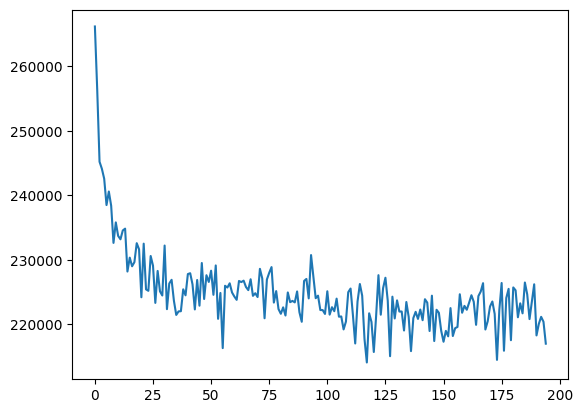

In [45]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(losses)), losses)

In [46]:
def generate_mnist(batch_size, model, z_dim=128, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    with torch.no_grad():
        z = torch.randn(batch_size, z_dim)
        out = model.to('cpu').decode(z).view(-1, 3, 32, 32).permute(0, 2, 3, 1)
        for i in range(batch_size):
            plt.subplot(2, batch_size, i+1)
            plt.imshow(out[i])

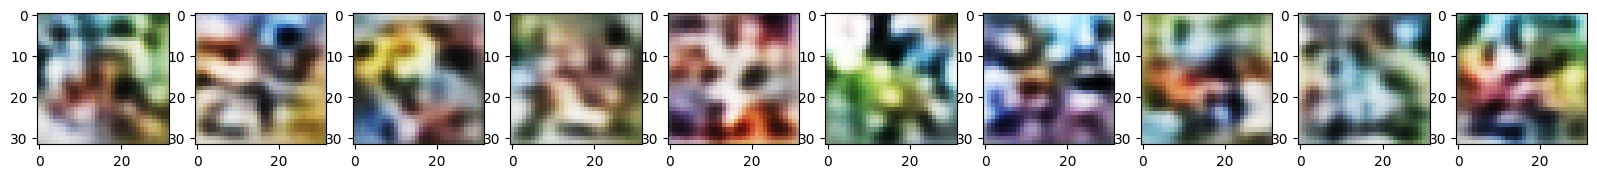

In [47]:
generate_mnist(10, vae_model, z_dim=128, figsize=(20,30))

## Resources

* [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
* [Variational inference: A review for statisticians](https://arxiv.org/pdf/1601.00670.pdf)
* [Tutorial on variational autoencoders](https://arxiv.org/pdf/1606.05908.pdf)
* [Stochastic Backpropagation and Approximate Inference in Deep Generative Models](https://arxiv.org/pdf/1401.4082.pdf)